In [1]:
import pandas as pd
import numpy as np 
import os
import sys

sys.path.append("..")
DATA_DIR = "~/Desktop/code/data/"

## Method 1

(Initially manual, can automate with new concentrations) 
For each EC number, map the ranges of concentrations used for the respective media (one media component at a time shown)

### Construction

In [2]:
# Load dataframe with CoCl2 media concentrations
cocl = pd.read_csv(os.path.join(DATA_DIR, "concentrations", "CoCl2_trimmed.csv"))

# Load dataframe with EC annotations
ec = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)

# Merge these dataframes to associate ec values w/ concentrations
coan = pd.merge(left=cocl, right=ec, on="media_id", how="left")
coec = coan.dropna(subset=["ec"])
filter = coec["ec"].str.contains("-")
coec = coec[~filter]

coec.head()

,solution,media_id,CoCl2,species,taxon_id,source,ec
0,Media,150a,0.6,Acidithiobacillus caldus,1736.0,uniprot,2.4.1.13
13,Allen,88a,0.0,Vulcanisaeta distributa,220670.0,uniprot,2.5.1.157
14,Allen,88a,0.0,Vulcanisaeta distributa,220670.0,uniprot,5.4.99.25
21,Allen,358a,0.0,Acidianus ambivalens,70586.0,uniprot,1.8.5.2
22,Allen,358a,0.0,Acidianus ambivalens,70586.0,uniprot,1.8.5.2


### Output

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

df = coec.copy()
ec_range = df.groupby('ec')['CoCl2'].agg(['min', 'max']).reset_index()
ec_range.columns = ['EC Number', 'Min Concentration', 'Max Concentration']

# Initialize
fig = go.Figure()

# Error bars
fig.add_trace(go.Scatter(
    x=ec_range['EC Number'],
    y=(ec_range['Max Concentration'] + ec_range['Min Concentration']) / 2,  # Mean concentration for y-axis
    error_y=dict(
        type='data',
        symmetric=False,
        array=(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2,
        arrayminus=(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2
    ),
    mode='markers',
    marker=dict(color='blue'),
    text=ec_range['EC Number'],  # Hover text
    hoverinfo='text',  # Show hover text
    name='Concentration Range'
))

# Update layout
fig.update_layout(
    title='Concentration Range for Each EC Number',
    xaxis_title='EC Number',
    yaxis_title='Concentration',
    xaxis_tickangle=-45
)

fig.show()

In [4]:
#TODO: add ability to map a test-set over this (maybe just highlight present EC numbers)

## Method 2

Collaborative Filtering (needs work)

### Construction

In [5]:
# Retrieve all available media from MediaDive
md_media_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media.csv")) # also has pH ranges...

# Create media_id_list
md_media_df = md_media_df.rename(columns={"id": "media_id"})
media_id_list = md_media_df["media_id"].astype(str).unique()

print(len(media_id_list), "unique media IDs")

# Retrieve solution/concentration info from MediaDive (run once, load after)
#import modules.mediadive as md
#media_info = md.get_concentrations(media_id_list)
#media_info.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"), index=False)

media_info = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"))
media_info.head()

3322 unique media IDs


,media_id,solutions,solution_names,components,component_ids,component_gL,steps,sub_solutions,solution_ids,solution_ml
0,1,[1],['Main sol. 1'],"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]","[5, 3, 15, None]","[[{'step': 'Adjust pH to 7.0.'}, {'step': 'For...",[],[],[]
1,1a,[3],['Main sol. 1a'],"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]","[5, 3, 15, None]",[[{'step': 'Adjust pH to 7.0. For Bacillus str...,[],[],[]
2,2,"[4, 1]","['Main sol. 2', 'Main sol. 1']","['Urea', 'Peptone', 'Meat extract', 'Agar', 'D...","[339, 1, 2, 3, 4]","[20, 5, 3, 15, None]",[[{'step': 'To medium 1 add 20 g/l urea before...,['Main sol. 1'],[1],[1000]
3,3,[5],['Main sol. 3'],"['Glucose', 'Mannitol', 'CaCl2 x 2 H2O', 'MgSO...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 3, 4]","[5, 5, 0.1, 0.1, 0.005, 0.9, 0.1, 0.01, 5, 15,...","[[{'step': 'Adjust pH to 7.3.'}, {'step': 'Ste...",[],[],[]
4,6,[6],['Main sol. 6'],"['K2HPO4', 'KH2PO4', 'MgSO4 x 7 H2O', 'CaCl2 x...","[10, 11, 8, 7, 12, 14, 15, 3, 4]","[0.8, 0.2, 0.5, 0.05, 0.01, 0.001, 20, 15, None]",[None],[],[],[]


In [6]:
# Explode on the components
media_exploded = media_info.explode(['components', 'component_ids', 'component_gL'])
media_exploded.reset_index(drop=True, inplace=True)
#media_exploded.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"), index=False)

# Format dataframe for collaborative filtering
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"))
md_df = md_df[["media_id", "components", "component_ids", "component_gL"]]

# Aggregate concentrations (component_gL) by summing duplicate component_ids for each media (occurs when multiple solutions w/ same ingredient)
md_grouped = md_df.groupby(['media_id', 'component_ids'], as_index=False).agg({'component_gL': 'sum'})

# Pivot (\/) ( ;,,;)(\/) whopp oop oop oop oop
concentrations = md_grouped.pivot(index='media_id', columns='component_ids', values='component_gL')

#concentrations.to_csv(os.path.join(DATA_DIR, "mediadive", "all-media-concentrations.csv"))
md_media_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media.csv"))
print(len(md_media_df), "total media,", len(concentrations), "with component_ids provided.")

concentrations.head()

3322 total media, 3134 with component_ids provided.


component_ids,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,2371.0,2375.0,2378.0,2384.0,2388.0,2389.0,2391.0,2394.0,2397.0,2398.0
media_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,15.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,0.0,NaN,NaN,0.014,0.34,0.01,0.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,0.0,NaN,NaN,0.100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Taxa-EC / media dataframe
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

filter = df["ec"].str.contains("-")
df = df[~filter]

df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering out MAGs
bins = df["media_id"].str.contains("unknown")
taxa2ec = df[~bins]

# Sum/aggregate by media_id
ec_grouped = taxa2ec.groupby('media_id', as_index=False).sum()

print(len(ec_grouped), "unique media_id's with associated taxa.")
ec_counts = ec_grouped.drop('taxon_id', axis=1)
ec_counts.to_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "ec-abundances.csv"), index=False)
ec_grouped.head()

581 unique media_id's with associated taxa.


ec,media_id,taxon_id,1.1.1.1,1.1.1.100,1.1.1.101,1.1.1.102,1.1.1.103,1.1.1.105,1.1.1.107,1.1.1.108,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,1012a,126734.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1031a,1794699.02142.0216932.0216933.0216934.0216937....,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,104a,306.0651822.066228.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,104b,1408819.01450156.01470356.01492.01501.01502.01...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,104c,1278232.01470354.0154288.0179628.01869227.0194...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


media_id overlap


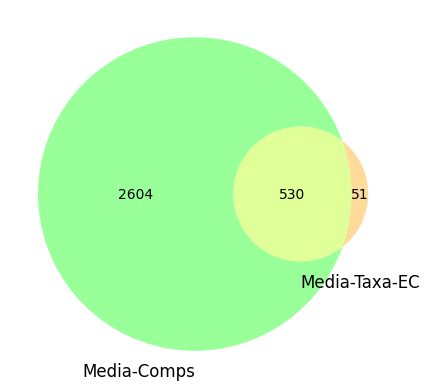

In [8]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

media = concentrations.index
taxa = ec_grouped["media_id"].to_list()

venn2(
    subsets=[set(media), set(taxa)],
    set_labels=["Media-Comps", "Media-Taxa-EC"],
    set_colors=["lime", "orange"]
    )

print("media_id overlap")

In [9]:
# List of media_id's w/ associated taxa, but no recipe in the MediaDive API (can manually check .pdf's)
media = concentrations.index
overlap = ec_grouped["media_id"].isin(media)
excluded_media = ec_grouped[~overlap]
omed = excluded_media["media_id"].to_list()

print(len(omed), "excluded media_ids")

# Add the omitted IDs to the concentration dataframe to prepare for merging
omed_ids = pd.DataFrame({'media_id': omed})
medcomp = concentrations.reset_index()
media_comps = pd.concat([medcomp, omed_ids], ignore_index=True) 

media_comps.to_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "media-concentrations.csv"), index=False)
media_comps

51 excluded media_ids


,media_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,2371.0,2375.0,2378.0,2384.0,2388.0,2389.0,2391.0,2394.0,2397.0,2398.0
0,1,5.0,3.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,NaN,NaN,15.0,0.0,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,NaN,NaN,NaN,0.0,NaN,NaN,0.014,0.34,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,NaN,NaN,NaN,0.0,NaN,NaN,0.100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,J894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3181,J934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3182,J960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3183,J972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
medcon = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "media-concentrations.csv")) # media concentrations
ecabun = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "ec-abundances.csv")) # sum of ec's for media-associated taxon

df_combined = pd.merge(medcon, ecabun, on="media_id")
df_combined

,media_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,1012a,NaN,NaN,12.0,0.0,NaN,NaN,0.30,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1031a,NaN,NaN,20.0,0.0,NaN,10.0,52.80,10.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,104a,NaN,NaN,NaN,0.0,NaN,NaN,0.25,0.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,104b,NaN,NaN,NaN,0.0,NaN,NaN,0.25,0.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,104c,NaN,NaN,NaN,0.0,NaN,NaN,0.25,0.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,J894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577,J934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578,J960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
579,J972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Applying an SVD model to predict concentrations:
df = df_combined.set_index('media_id')
df_cleaned = df.dropna(axis=1, how='all')

# Imputation Model
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df_cleaned)
n_components = min(data_imputed.shape) - 1  # Use one less than the smaller dimension
svd = TruncatedSVD(n_components=n_components)

media_matrix = svd.fit_transform(data_imputed)
ingredient_matrix = svd.components_
reconstructed_data = np.dot(media_matrix, ingredient_matrix)

data_filled_svd = np.where(np.isnan(df_cleaned.values), reconstructed_data, df_cleaned.values)
svd_output = pd.DataFrame(data_filled_svd, index=df_cleaned.index, columns=df_cleaned.columns)

svd_output

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
media_id,,,,,,,,,,,,,,,,,,,,,
1012a,4.144383,4.055556,12.000000,0.000000e+00,6.879133,17.5,0.30000,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1031a,4.144383,4.055556,20.000000,0.000000e+00,6.879133,10.0,52.80000,10.000000,0.043801,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104a,4.144383,4.055556,15.564965,0.000000e+00,6.879133,17.5,0.25000,0.500000,0.043801,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104b,4.144383,4.055556,15.564965,0.000000e+00,6.879133,17.5,0.25000,0.500000,0.043801,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104c,4.144383,4.055556,15.564965,0.000000e+00,6.879133,17.5,0.25000,0.500000,0.043801,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J894,4.144383,4.055556,15.564965,-5.944294e-14,6.879133,17.5,1.81717,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J934,4.144383,4.055556,15.564965,-6.247341e-14,6.879133,17.5,1.81717,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J960,4.144383,4.055556,15.564965,-6.115253e-14,6.879133,17.5,1.81717,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test Sample

In [12]:
# Formatting a test sample:
ml_input = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

bins = ml_input["source"].str.contains("KBase")
mag = ml_input[bins]
test = mag["taxon_id"].str.contains("Bin.001.fastaBA_F_") # selecting individual MAG
sample = mag[test]

sample["count"] = 1
new_sample = sample.pivot_table(index='taxon_id', columns='ec', values='count', fill_value=0)
new_sample.reset_index(inplace=True)
new_sample = new_sample.rename(columns={"taxon_id": "media_id"})

new_sample.head()

C:\Users\jakel\AppData\Local\Temp\ipykernel_11460\2661495130.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ec,media_id,1.1.1.141,1.1.1.23,1.1.1.25,1.1.1.267,1.1.1.3,1.1.1.31,1.1.1.85,1.1.1.86,1.1.1.94,...,6.6.1.1,6.6.1.2,7.1.1.2,7.1.1.9,7.1.2.2,7.3.2.1,7.3.2.2,7.3.2.5,7.3.2.6,7.4.2.8
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Output

In [13]:
# Apply the same imputation model
df_new_sample = new_sample.set_index('media_id')
df_new_sample = df_new_sample.reindex(columns=df_cleaned.columns, fill_value=0)

data_new_sample_imputed = imputer.transform(df_new_sample)
media_matrix_new = svd.transform(data_new_sample_imputed)
reconstructed_data_new = np.dot(media_matrix_new, svd.components_)

df_reconstructed_new = pd.DataFrame(reconstructed_data_new, index=df_new_sample.index, columns=df_cleaned.columns)
df_reconstructed_new.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
media_id,,,,,,,,,,,,,,,,,,,,,
KBase_derived_Bin.001.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff,-7.911286e-15,2.853545e-14,-2.325591e-15,0.007218,5.563448e-15,-1.365675e-14,-1.532628e-14,6.402474e-17,-6.688022e-13,1.539499e-16,...,-0.002295,0.017305,0.447325,-0.013047,0.011521,0.026925,0.05749,0.052979,-0.117274,-0.015624


In [14]:
# Only show components above a threshold of a certain value
threshold = 0.05 # e.g., don't show components with concentrations below 0.5 g/L

df_filtered = df_reconstructed_new[df_reconstructed_new > threshold]
df_filtered_cleaned = df_filtered.dropna(axis=1, how='all')
df_filtered_cleaned = df_filtered_cleaned.dropna(axis=0, how='all')

df_filtered_cleaned.head()

,24.0,45.0,94.0,96.0,115.0,135.0,149.0,339.0,421.0,702.0,...,7.4.2.8,7.4.2.9,7.5.2.10,7.5.2.11,7.5.2.13,7.5.2.7,7.6.2.11,7.6.2.14,7.6.2.5,7.6.2.7
media_id,,,,,,,,,,,,,,,,,,,,,
KBase_derived_Bin.001.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff,0.079969,0.159097,0.059464,0.146081,0.067324,0.124784,0.090293,0.411334,0.052126,0.273212,...,0.390843,0.107971,0.132405,0.200665,0.170672,0.181072,0.173863,0.447325,0.05749,0.052979


NOTE: method 2 currently appears to drastically underreport concentrations; need to find a middle-ground between methods 1 and 2

## Method 3

Using the means of clusters (or nearest neighbors?) to predict media component concentrations for each sample

### Construction

In [15]:
ml_output = pd.read_csv(os.path.join(DATA_DIR, "model", "ml-model-output.csv"))

#df = ml_output.drop(ml_output.columns[0:32], axis=1)
df = ml_output[["taxon_id", "Test Cluster", "RF Classify", "KNN Classify", "neighbor_taxon_id", "neighbor_media_id"]]
df = df.rename(columns={
    "taxon_id": "bin_name", 
    "Test Cluster": "KM_cluster",
    "RF Classify": "RF_cluster",
    "KNN Classify": "KN_cluster"
    #"neighbor_media_id": "media_id"
})

df.head()

,bin_name,KM_cluster,RF_cluster,KN_cluster,neighbor_taxon_id,neighbor_media_id
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,33018.0,J92
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,65958.0,J960
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,1520.0,87a
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,589382.0,J27


In [16]:
media_info = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"))

# Explode on the components
media_exploded = media_info.explode(['components', 'component_ids', 'component_gL'])
media_exploded.reset_index(drop=True, inplace=True)
#media_exploded.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"), index=False)

# Format dataframe for collaborative filtering
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"))
md_df = md_df[["media_id", "components", "component_ids", "component_gL"]]

# Aggregate concentrations (component_gL) by summing duplicate component_ids for each media (occurs when multiple solutions w/ same ingredient)
#md_grouped = md_df.groupby(['media_id', 'component_ids'], as_index=False).agg({'component_gL': 'sum'})

# Merge with the neighbor data
merged = df.merge(md_df, left_on='neighbor_media_id', right_on='media_id', how='left') #or md_grouped rather than md_df
merged.head()

,bin_name,KM_cluster,RF_cluster,KN_cluster,neighbor_taxon_id,neighbor_media_id,media_id,components,component_ids,component_gL
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,KH2PO4,11.0,0.50
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,NH4Cl,42.0,1.00
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,Na2SO4,110.0,4.50
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,CaCl2 x 2 H2O,7.0,0.06
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,MgSO4 x 7 H2O,8.0,0.06


In [17]:
df_means = merged.groupby(['bin_name', 'KM_cluster', 'RF_cluster', 'KN_cluster', 'components', 'component_ids'])['component_gL'].mean().reset_index()
df_means.head()

,bin_name,KM_cluster,RF_cluster,KN_cluster,components,component_ids,component_gL
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,(NH4)2SO4,27.0,2.997000
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Biotin,46.0,0.050000
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Ca(NO3)2,266.0,0.009990
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,CaCl2 x 2 H2O,7.0,0.053809
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Calcium pantothenate,518.0,0.500000


### Output

In [18]:
# Filter through different test bins for media output based on nearest neighbors
test = df_means["bin_name"].str.contains("Bin.001.fastaBA_F_e")
test_df = df_means[test]
test_df.head()

#TODO: combine with taxonomy data? i.e., take nearest neighbors taxonomy info into account 

,bin_name,KM_cluster,RF_cluster,KN_cluster,components,component_ids,component_gL
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,(NH4)2SO4,27.0,2.997000
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Biotin,46.0,0.050000
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Ca(NO3)2,266.0,0.009990
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,CaCl2 x 2 H2O,7.0,0.053809
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Calcium pantothenate,518.0,0.500000
